In [1]:
import pandas as pd
import numpy as np
from lreg import LogisticRegression as lr
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.svm import SVC

import matplotlib.pyplot as plt

import time

In [2]:
# читаем датасет
df = pd.read_csv( 'adult.csv' )
# все признаки
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [3]:
# анализируемые признаки
used_cols = [
        'age', # гаусс, но обрезанный, только больше 12 лет где-то - https://prnt.sc/w82zxx  - можно попробовать нормировать
    'workclass',  # отключено для ускорения переписанной numpy-ml
    # 'fnlwgt', # пока не трогаю, оценку ухудшает
    #  'education', # есть цифровой признак - этот не нужен - попробовал, ухудшает score
        'educational-num', # можно попробовать нормировать - есть центральные максимумы, хвост слева, но посередине дырка
    #    'marital-status',  # отключено для ускорения переписанной numpy-ml
    #    'occupation',  # отключено для ускорения переписанной numpy-ml
    #    'relationship',  # отключено для ускорения переписанной numpy-ml
    #    'race',  # отключено для ускорения переписанной numpy-ml
    #    'gender', #  # отключено для ускорения переписанной numpy-ml
    #    'capital-gain', # распределение скорее пуассоновское  # отключено для ускорения переписанной numpy-ml
      #  'capital-loss', # очень мало не 0 -  сильно (на 3%) ухудшает score. странно, может нужно с обратным знаком брать?
    #    'hours-per-week', # отключено для ускорения переписанной numpy-ml
    #    'native-country', # интересно - ухудшает оценку
    #    'income' - целевой признак
       ]
# нечисловые признаки
cat_cols = ['gender', 'race', 'marital-status','occupation','relationship','education','workclass', 'native-country',
#  'capital-loss'
 ]


,age,workclass,educational-num
0,-0.995129,Private,-1.197259
1,-0.046942,Private,-0.419335
2,-0.776316,Local-gov,0.747550
3,0.390683,Private,-0.030373
4,-1.505691,?,-0.030373
...,...,...,...
48837,-0.849254,Private,0.747550
48838,0.098933,Private,-0.419335
48839,1.411808,Private,-0.419335
48840,-1.213941,Private,-0.419335


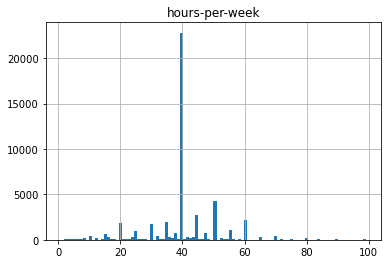

In [4]:

scaler = StandardScaler()
# cols_w_zeros = ['capital-gain',] 
# df[cols_w_zeros] = df[cols_w_zeros].replace({0:np.nan}) # None не переваривается скейлером - только дропать
df = pd.read_csv( 'adult.csv' )
df['index1'] = df.index
# scaler.fit(df[['index1','age']])
cols_to_norm = ['index1','age',
'educational-num',
 'hours-per-week',
 'capital-gain'
 ]
dff = df.copy()

df.hist(column='hours-per-week',bins=100) # before scaling

dff[cols_to_norm] = pd.DataFrame(scaler.fit_transform(df[cols_to_norm]),columns=cols_to_norm)
# dff.hist(column='hours-per-week',bins=100) # after scaling

# X = dff[used_cols]
dff[used_cols]

0.8539521032386153 - максимальный score на 2020-12-23--11-35 - со стандартизацией величин, которые как-то похожи на стандартные  
0.8435910162551185 - максимальный score на 2020-12-21--21-10 - просто за счет выбора колонок, без преобработки скейлерами



In [5]:

X = pd.get_dummies(dff[used_cols], columns=[c for c in cat_cols if c in used_cols])

le = LabelEncoder()
le.fit( df['income'] )
# le.classes_
y = pd.Series( data = le.transform( df['income'] ) )

test_s = 50
train_s = 50

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_s, train_size=train_s, random_state=42)

model = LogisticRegression()
model.fit( X_train, y_train )
# predictions = model.predict_proba( X_train )
model.predict(X)
model.score(X_test, y_test)
# from sklearn.metrics import accuracy_score
# accuracy_score(y_test,  model.predict(X_test))

0.86

In [7]:
model2 = SVC(kernel='rbf', degree=1, gamma='scale') 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_s, train_size = train_s, random_state=42)

model2.fit(X_train, y_train)
model2.score(X_test,y_test)

0.82

0.8604045166894155 - с train_size = 10 000, kernel='rbf', gamma='scale' - лучше, чем у лин. регрессии  
0.8509120238242959 - с train_size = 10 000, kernel='poly', degree=1  
0.8451420771807917 - с train_size = 1 000, kernel='poly', degree=1  
0.8489266658394342 - с train_size = 10 000, kernel='linear'

In [8]:
test_s = 1000
train_s = 1000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_s, train_size=train_s, random_state=42)

In [9]:
model = lr()
start = time.time()
model.fit( X_train, y_train, lr=0.01, max_iter=1e4, method='sgd' )
print(time.time() - start)

print('\nscore:')
from sklearn.metrics import accuracy_score
accuracy_score(y_test,  np.around(model.predict(X_test)))

4.306996583938599

score:


0.785

In [10]:
model = lr()
start = time.time()
model.fit( X_train, y_train, lr=0.01, max_iter=1e4, method='momentum', hist_w=0. )
print(time.time() - start)

print('\nscore:')
from sklearn.metrics import accuracy_score
accuracy_score(y_test,  np.around(model.predict(X_test)))

4.389995336532593

score:


0.787

In [11]:
model = lr()
start = time.time()
model.fit( X_train, y_train, lr=0.01, max_iter=1e4, method='rmsprop', hist_w=0. )
print(time.time() - start)

print('\nscore:')
from sklearn.metrics import accuracy_score
accuracy_score(y_test,  np.around(model.predict(X_test)))

0.6200320720672607

score:


0.789

In [12]:
model = lr()
start = time.time()
model.fit( X_train, y_train, lr=0.01, max_iter=1e4, method='nag', hist_w=0. )
print(time.time() - start)

print('\nscore:')
from sklearn.metrics import accuracy_score
accuracy_score(y_test,  np.around(model.predict(X_test)))

6.10503363609314

score:


0.788

In [13]:
# Контрольный расчет: проверить, что ничего основного не сломано - numply_ml без изменений, sgd
from lreg_numpyml_pure import LogisticRegression as lr_p
model = lr_p()
start = time.time()
model.fit( X_train, y_train, lr=0.01, max_iter=1e4)
print(time.time() - start)

print('\nscore:')
from sklearn.metrics import accuracy_score
accuracy_score(y_test,  np.around(model.predict(X_test)))

4.628997564315796

score:


0.787